In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
loan=pd.read_csv('../cleaned_loan.csv')
loan.shape

(257777, 25)

In [5]:
X=loan.drop(columns=['loan_status','loan_status_grouped','emp_title','purpose','title','issue_d','grade'])
y=loan['loan_status_grouped']

In [6]:
X.shape

(257777, 18)

In [7]:
X.head()

,annual_inc,delinq_2yrs,dti,emp_length,funded_amnt,home_ownership,inq_last_6mths,installment,int_rate,loan_amnt,mths_since_last_delinq,pub_rec,sub_grade,term,total_acc,total_pymnt,acc_now_delinq,log_annual_inc
0,24000.0,0.0,27.65,10+ years,5000.0,RENT,1.0,162.87,10.65,5000.0,0.0,0.0,B2,36 months,9.0,5861.071414,0.0,10.085809
1,30000.0,0.0,1.00,< 1 year,2500.0,RENT,5.0,59.83,15.27,2500.0,0.0,0.0,C4,60 months,4.0,1008.710000,0.0,10.308953
2,12252.0,0.0,8.72,10+ years,2400.0,RENT,2.0,84.33,15.96,2400.0,0.0,0.0,C5,36 months,10.0,3003.653644,0.0,9.413444
3,49200.0,0.0,20.00,10+ years,10000.0,RENT,1.0,339.31,13.49,10000.0,35.0,0.0,C1,36 months,37.0,12226.302212,0.0,10.803649
4,36000.0,0.0,11.20,3 years,5000.0,RENT,3.0,156.46,7.90,5000.0,0.0,0.0,A4,36 months,12.0,5631.377753,0.0,10.491274


In [8]:
# Encode sub_grade into numerical values
def sub_grades_encoding(x):
    grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
    number_mapping = {'1': 0.8, '2': 0.6, '3': 0.4, '4': 0.2, '5': 0.0}
    
    val = grade_mapping.get(x[0], 0) + number_mapping.get(x[1], 0)
    return val

X['sub_grade']= X['sub_grade'].apply(sub_grades_encoding)

#Separate numerical and non-numerical columns
ordinal_columns = ['emp_length']
categorical_columns = ['home_ownership', 'term']
numerical_columns = X.select_dtypes(include=['float64']).columns

# Apply Label Encoding to ordinal columns before splitting
le = LabelEncoder()
for col in ordinal_columns:
    X[col] = le.fit_transform(X[col])

# Apply OneHotEncoding to categorical columns before splitting
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Ensure the train and test sets have the same structure (dummies already handled)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Apply scaling to numerical columns
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Coefficients: [[ 4.26864627e-02 -6.92184649e-04  3.61869486e-02  3.27103286e-03
   8.91158027e+00  1.14055809e-01  2.91701644e+00  9.50086751e-01
   1.70783177e+00  1.26283436e-02 -1.61404391e-01  5.59408694e-01
  -1.49289842e-01 -1.58510865e+01 -3.61352247e-02 -2.25307167e-01
  -1.48096812e-02 -3.94929570e-01  1.55095250e-01  5.19419524e-01
  -4.99502858e-01 -2.90789685e-01 -9.39459827e-01  4.13942807e-01]] 

Intercept: [-0.59852065] 

Accuracy: 0.98 

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     40328
         1.0       0.99      0.91      0.95     11228

    accuracy                           0.98     51556
   macro avg       0.98      0.95      0.97     51556
weighted avg       0.98      0.98      0.98     51556



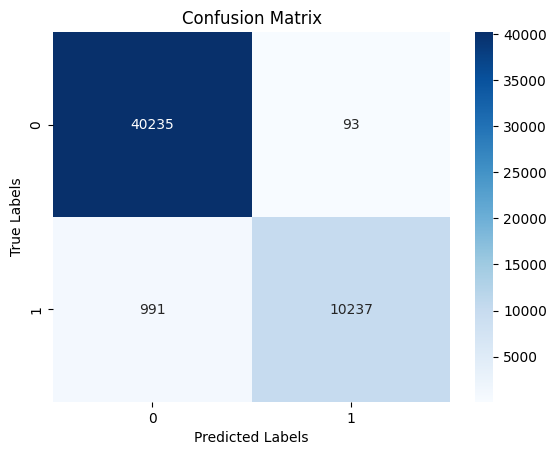

In [9]:
# Fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions using a threshold of 0.5,
# meaning only loans with >= 0.5 probability of repayment will be classified as repaid
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# Print coefficients and intercept
print("Coefficients:", model.coef_, "\n")
print("Intercept:", model.intercept_, "\n")

# Generate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the accuracy score and classication report
print(f'Accuracy: {accuracy:.2f}',"\n")
print("Classification Report:\n", class_report)

# Plot confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=True, xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
